# Marketing - Depósito
- dataset: [kaggle - bankfull](https://www.kaggle.com/krantiswalke/bankfullcsv)

**Resumo**: Neste manuscrito, analisamos um dataset referente à campanhas de marketing de uma instituição bancária sobre uma assinatura de serviço. Tal assinatura é realizada quando o cliente efetua um depósito, indicado pela coluna 'y' (denotada como classe). Ademais, posteriormente à análise exploratória, construímos um modelo de machine learning para prevê-lo. Avaliamos dois modelos: *regressão logística* e *SVM*. O primeiro nos permitiu avaliar a importância dos atributos perante à classe (suas influências sobre a decisão do cliente em efetuar o depósito), assim nos possibilitando simplificá-lo, de modo a mantermos somente os mais relevantes, havendo uma negligenciável diferença de performance. O segundo mostra um desempenho similar ao primeiro, mas devido à sua complexidade (tempo necessário para ser executado---muito maior que o primeiro) será preferível a regressão.

**Roadmap**:

1. compreender os dados de cada coluna e analisar suas distribuições;
2. pré-processamento dos dados com LabelEncoder e NearMiss (classes desbalanceadas);
3. modelos
    1. implementação do modelo de regressão logística;
        - re-execução com os parâmetros mais importantes;
        - tunning dos parâmetros;
    2. implementação do modelo de SVM;
        - re-execução com os parâmetros mais importantes;
        - tunning dos parâmetros;
    3. implementação do modelo NaiveBayes;
4. conclusões.

In [2]:
import pandas as pd
import numpy as np
import functions_aux as aux
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import visuals

## 1. EDA
- Colunas (cat - categórico/num - numérico):
0. age (num): idade
1. job (cat): emprego
2. marital (cat): estado civil
3. education (cat): nível de educação
4. default (cat): possui crédito inadimplente?
5. balance (num): média do balanço anual, em euros
6. housing (cat): possui empréstimo para propriedade?
7. loan (cat): possui empréstimo pessoal?
8. contact (cat): tipo do contato para comunicação
9. day (num): dia do mês do último contato
10. month (cat): mês do ano do último contato
11. duration (num): duração do último contato (na documentação, recomenda-se seu descarte)
12. campaign (num): número de contatos realizados durante a campanha atual
13. pdays (num): número de dias que se passaram do último contato sobre uma campanha anterior
14. previous (num): número de contatos realizados antes da campanha atual
15. poutcome (cat): retorno da campanha anterior
16. y (cat): cliente realizou o depósito?

In [3]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# convertendo os dados do tipo object para category
# e int64 para int32
for c in df.columns:
    if df.dtypes[c] == 'object':
        df[c] = df[c].astype('category')
    elif df.dtypes[c] == 'int64':
        df[c] = df[c].astype('int32')

### Colunas numéricas

- age: a idade dos clientes varia entre 18 a 95 anos, com a maioria entre 30 e 50, e pouquíssimos com idade superior a 60.

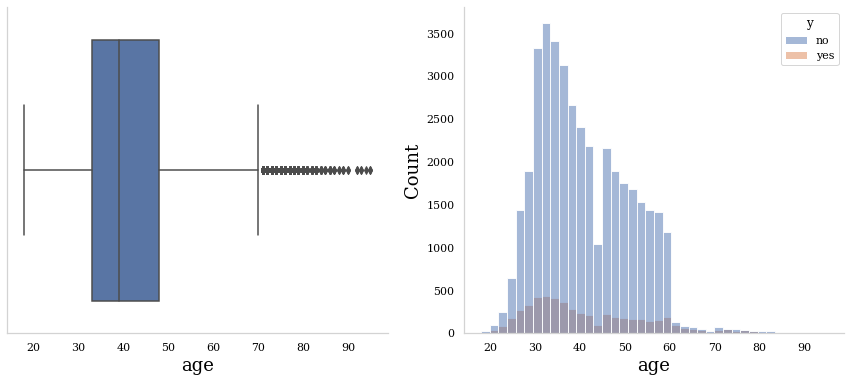

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='age', data=df);

plt.subplot(1, 2, 2)
sns.histplot(x='age', data=df, bins=40, hue='y');

In [13]:
df['age'].describe()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

- balance: há muita variação sobre esta variável, indo de -8k até >100k. Para melhor visualização categorizaremos os clientes.

In [14]:
df['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [6]:
df['balance_status'] = df['balance'].apply(aux.categorize)

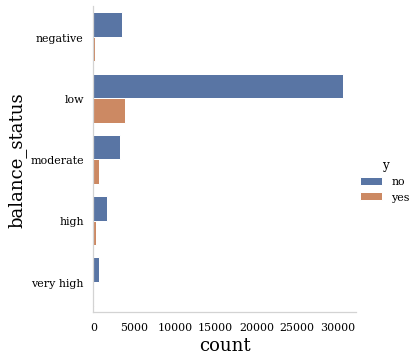

In [10]:
sns.catplot(
    y='balance_status',
    data=df,
    kind='count',
    order=['negative', 'low', 'moderate', 'high', 'very high'],
    hue='y'
);

- day: parece haver uma maior probabilidade de efetivação do depósito em torno dos dias 15 e 30.

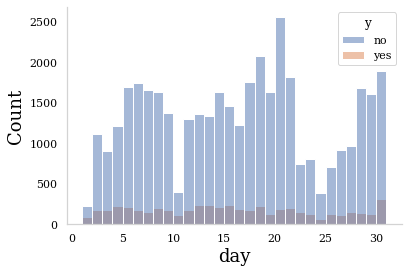

In [11]:
sns.histplot(x='day', data=df, bins=30, hue='y');

- duration (a ser removida para implementação dos modelos)

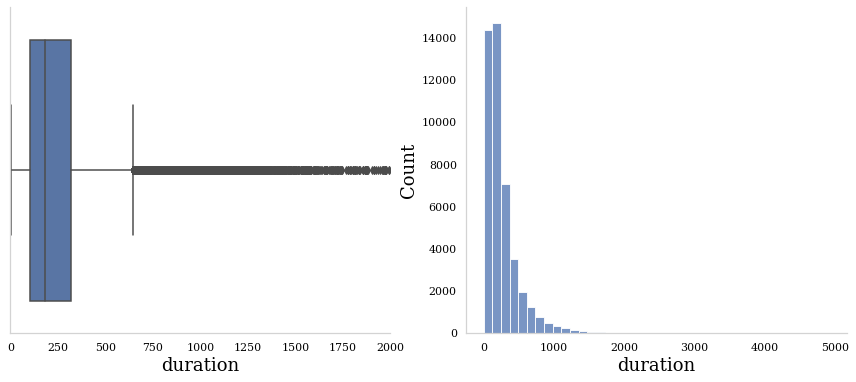

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='duration', data=df);

plt.xlim(-5, 2000)

plt.subplot(1, 2, 2)
sns.histplot(x='duration', data=df, bins=40);

In [45]:
df['duration'].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

- campaign: há uma grande concentração no número de contatos entre 1 e 2, com uma queda significativa a partir de 3. Maior que 6 contatos temos $\approx$ 3k.

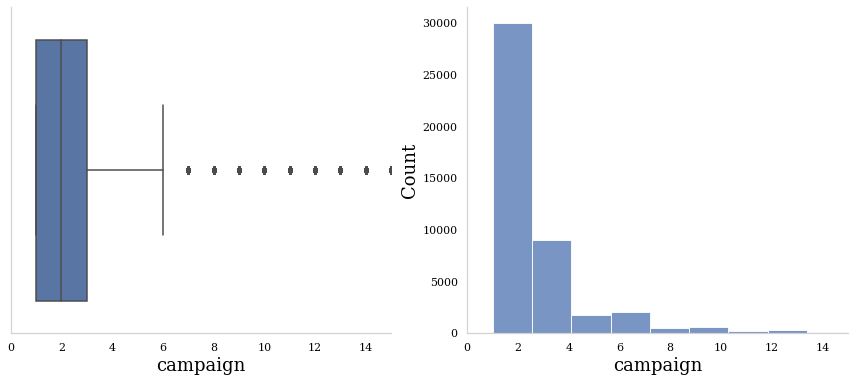

In [12]:
# limitaremos o domínio para melhor visualização
fig, ax = plt.subplots(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='campaign', data=df);

plt.xlim(0, 15);

plt.subplot(1, 2, 2)
sns.histplot(x='campaign', data=df, bins=40);

plt.xlim(0, 15);

In [19]:
df['campaign'].describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

- pdays: há uma grande concentração no valor -1, agrupando $\approx$ 37k dos dados. Ao analisarmos os dados sobre 'previous', verificamos que estes correspondem a usuários que nunca foram contactados.

- previous: grande concentração no valor 0, com $\approx$ 37k. Em outras palavras, a maioria dos usuários nunca foi contactada.

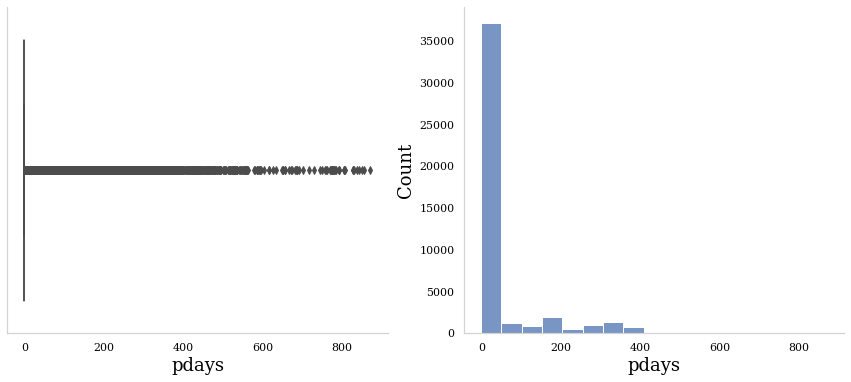

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='pdays', data=df);

plt.subplot(1, 2, 2)
sns.histplot(x='pdays', data=df);

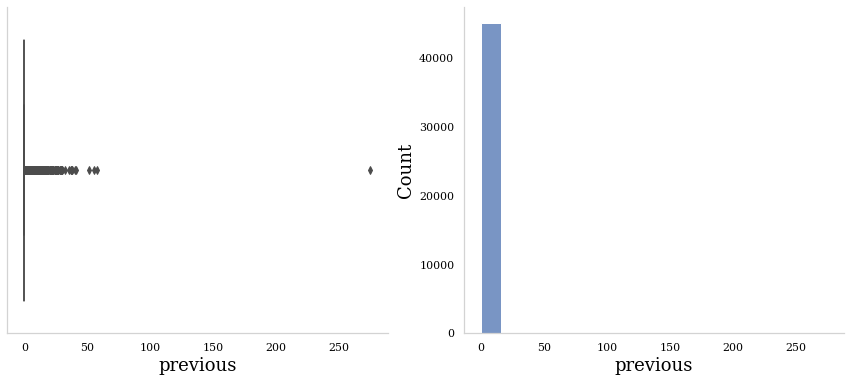

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='previous', data=df);

plt.subplot(1, 2, 2)
sns.histplot(x='previous', data=df);

## Colunas categóricas

- job: observamos que a maioria dos clientes vem das classes blue-collar (trabalhos braçais), management (gestão) e técnico.

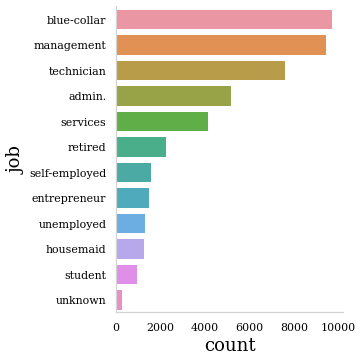

In [15]:
sns.catplot(
    y='job',
    kind='count',
    data=df,
    order=df['job'].value_counts().index
);

- marital: a maioria é casado.

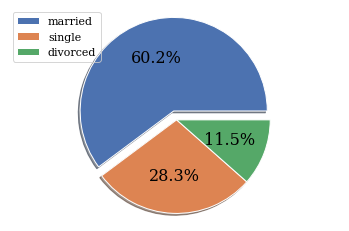

In [6]:
s = df['marital'].value_counts()

plt.pie(
    s,
    autopct='%1.1f%%',
    explode=(.1, 0, 0),
    shadow=True
)
plt.legend(s.index, loc=2)
plt.axis('equal')
plt.show()

- education: a maioria possui ensino médio completo (secondary education)

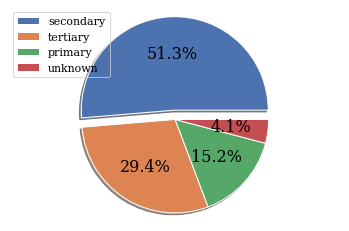

In [5]:
s = df['education'].value_counts()

plt.pie(
    s,
    autopct='%1.1f%%',
    explode=(.1, 0, 0, 0),
    shadow=True
)
plt.legend(s.index, loc=2)
plt.axis('equal')
plt.show()

- default: praticamente todos os entrevistados não são inadimplentes

- housing e personal: a maioria possui empréstimo para propriedade, mas não possui empréstimo pessoal

- y: a maioria não realizou o depósito (também notamos um desbalanceamento entre as classes)

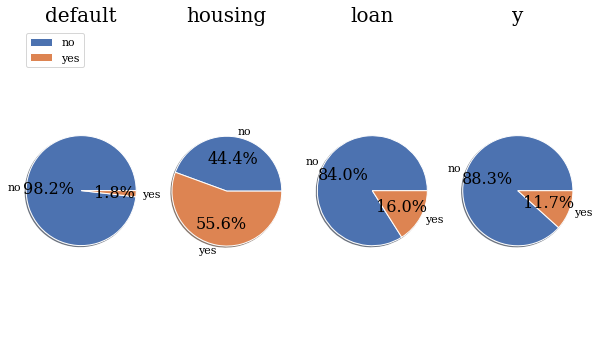

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

for col, k in zip(['default', 'housing', 'loan', 'y'], range(1, 5)):
    plt.subplot(1, 4, k)

    plt.pie(
        aux.prop_yes(df, col, 'v'),
        labels=aux.prop_yes(df, col),
        colors=aux.colors,
        autopct='%1.1f%%',
        shadow=True
    )
    if k == 1:
        plt.legend(['no', 'yes'], loc=2)

    plt.title(col)
    plt.axis('equal')
plt.show()

- contact: a maioria dos contatos realizados foi por celular

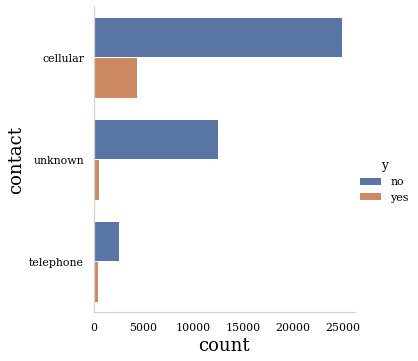

In [26]:
sns.catplot(
    y='contact',
    kind='count',
    data=df,
    order=df['contact'].value_counts().index,
    hue='y'
);

- month: os meses com maior proporção de clientes que realizaram o depósito foram: março, setembro, dezembro e outubro.

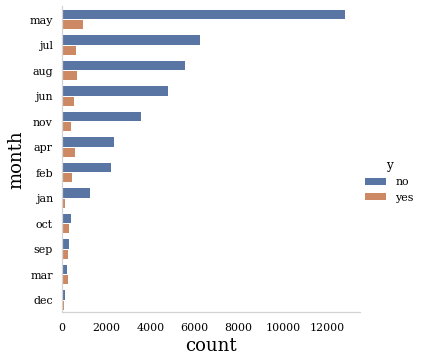

In [27]:
sns.catplot(
    y='month',
    kind='count',
    data=df,
    order=df['month'].value_counts().index,
    hue='y'
);

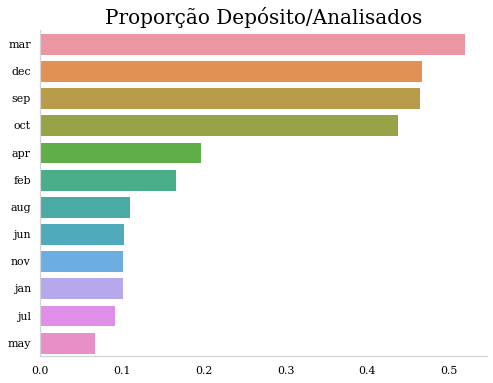

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    x=aux.prop_yes(df, 'month', 'v'),
    y=aux.prop_yes(df, 'month'),
    order=[
        m[0] for m in sorted(aux.prop_yes(df, 'month', 'd').items(),
                             key=lambda i: i[1], reverse=True)
    ]
);
plt.title('Proporção Depósito/Analisados');

- poutcome: observamos uma maior probabilidade da efetivação do depósito dado que esta já ocorreu em campanhas anteriores. Porém, como 90% dos dados referente a esta coluna é desconhecido, achamos mais proveitoso removê-la do tratamento.

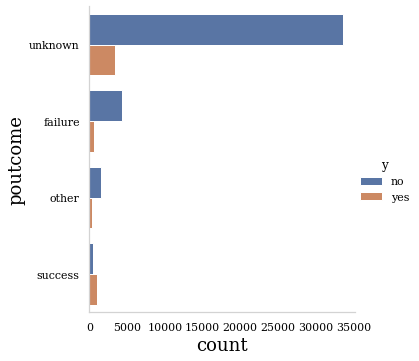

In [37]:
sns.catplot(
    y='poutcome',
    kind='count',
    data=df,
    order=df['poutcome'].value_counts().index,
    hue='y'
);

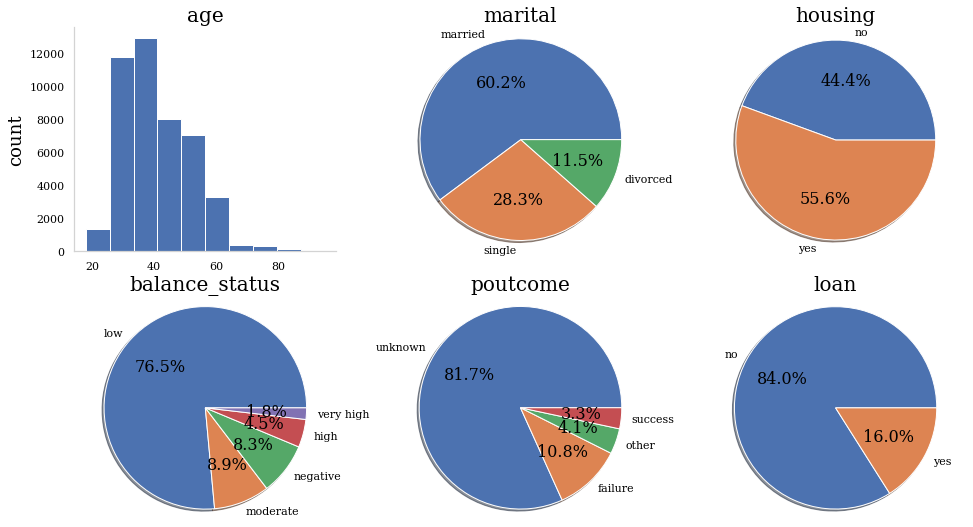

In [38]:
f, ax = plt.subplots(figsize=(16, 14))

cols = [
    'age', 'marital', 'housing',
    'balance_status', 'poutcome', 'loan'
]

for col, k in zip(cols, range(1, 7)):
    plt.subplot(3, 3, k)

    if k != 1:
        series = df[col].value_counts()

        value = lambda x: aux.prop_yes(df, x, 'v') \
            if x in ['housing', 'loan'] else series.values

        label = lambda x: aux.prop_yes(df, x) \
            if x in ['housing', 'loan'] else series.index

        plt.pie(
            value(col),
            labels=label(col),
            autopct='%1.1f%%',
            shadow=True,
            normalize=True
        )
        plt.axis('equal')
    else:
        plt.hist(
            x=col,
            data=df
        );
        plt.xlabel(None);
        plt.ylabel('count');

    plt.title(col)

plt.tight_layout
plt.show()

- analisemos somente aqueles que realizaram o depósito

In [ ]:
df_yes = df[df['y'] == 'yes']

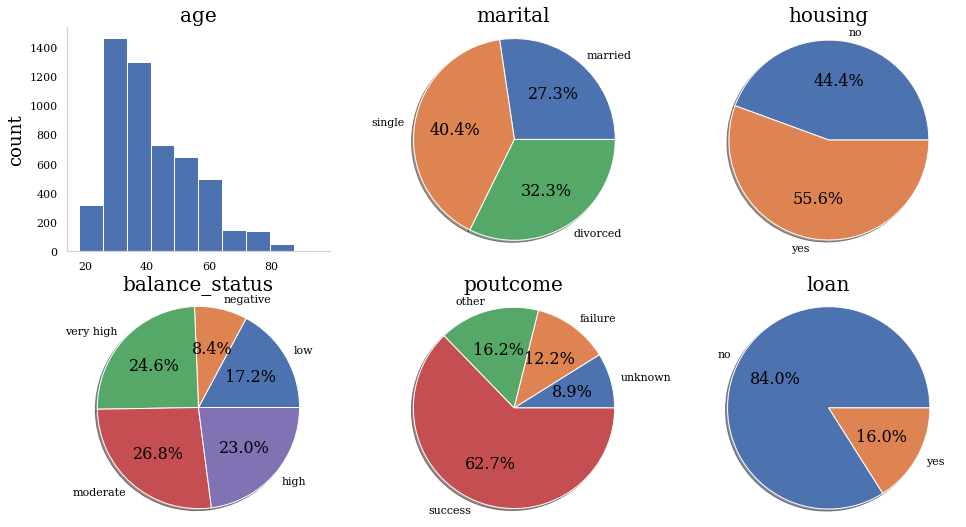

In [ ]:
f, ax = plt.subplots(figsize=(16, 14))

cols = [
    'age', 'marital', 'housing',
    'balance_status', 'poutcome', 'loan'
]

for col, n in zip(cols, range(1, 7)):
    plt.subplot(3, 3, n)

    if n != 1:
        plt.pie(
            aux.prop_yes(df, col, 'v'),
            labels=aux.prop_yes(df, col),
            autopct='%1.1f%%',
            shadow=True,
            normalize=True
        )
        plt.axis('equal')
    else:
        plt.hist(
            x=col,
            data=df_yes
        );
        plt.xlabel(None);
        plt.ylabel('count');

    plt.title(col)

plt.tight_layout
plt.show()

- correlações: a baixa correlação entre a maioria dos atributos nos sugere um modelo do tipo Naive Bayes.

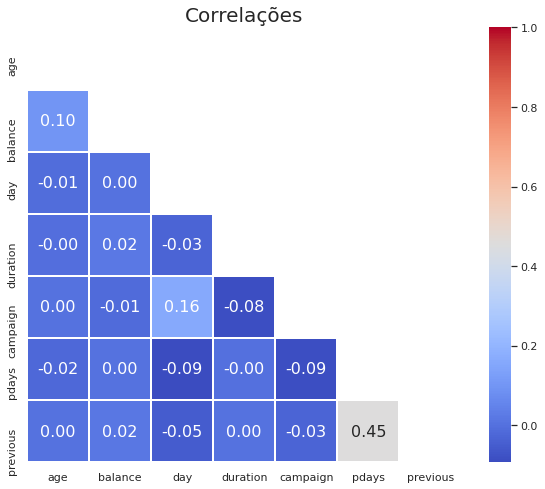

In [48]:
correlations = df.select_dtypes(include='int32').corr()

# como desejamos limpar um pouco o heatmap, mostraremos somente a metade inferior
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(correlations, mask=mask, annot=True,
                     cmap='coolwarm', fmt='.2f', linewidths=0.05,
                     vmax=1.0, square=True, linecolor='white')

plt.title('Correlações');
plt.xlabel(None);
plt.ylabel(None);

### Conclusões preliminares
A grande maioria das pessoas que realizaram o depósito:
- possui idade em torno de 35 anos;
- é solteira;
- já o realizaram em campanhas anteriores (debatível, dado que a maioria desses dados na verdade é desconhecida);
- possui um balanço anual > 2.5k;
- não realizou nenhum tipo de empréstimo

Também há indícios de que os meses de março, setembro, outubro e dezembro são os mais propícios à realização do depósito.

## 2. Pré-Processamento

Aplicando LabelEncoder nas colunas categóricas.

In [5]:
# como instruído na documentação, a coluna duration será removida
# e, como discutido na seção anterior, também removeremos poutcome
df.drop(['duration', 'poutcome'], axis=1, inplace=True)

cat_cols = [
    c for c in df.columns if df[c].dtype != 'int32'
]

df_ = aux.col_encoder(df, cat_cols)

## 3. Modelos
### 3.1 Regressão Logística V1

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
# dados pre-processados
X_train, X_test, y_train, y_test = aux.full_preprocess(df_, 'tt')

# instanciando o modelo
lr = LogisticRegression()

# treinando-o
lr.fit(X_train, y_train)

# realizando as predições
y_pred = lr.predict(X_test)

# métricas de avaliação
aux.score_metrics(lr, X_train, X_test, y_train, y_test, y_pred)

MAE: 0.15236294896030245
RSME: 0.39033696847762506
Acurácia (teste, treino): (0.8476370510396976, 0.8588175973780411)


In [8]:
aux.plot_report_confusion(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1322
           1       0.95      0.74      0.83      1323

    accuracy                           0.85      2645
   macro avg       0.87      0.85      0.85      2645
weighted avg       0.87      0.85      0.85      2645

     Predito     0     1   All
Real                          
0             1267    55  1322
1              348   975  1323
All           1615  1030  2645


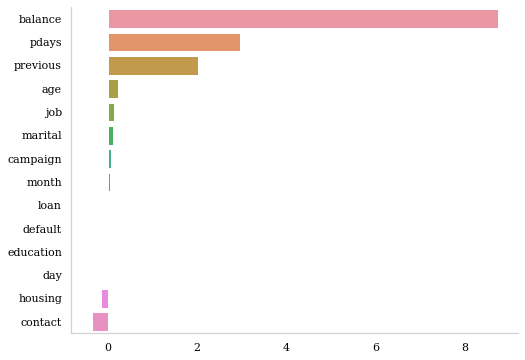

In [10]:
X = df_.drop('y', axis=1)
aux.plot_features(lr.coef_, X.columns)

Observamos uma grande irrelevância de vários atributos. Refaremos o modelo considerando apenas as colunas: *balance*, *pdays*, *previous*, *age*, *housing* e *contact*.

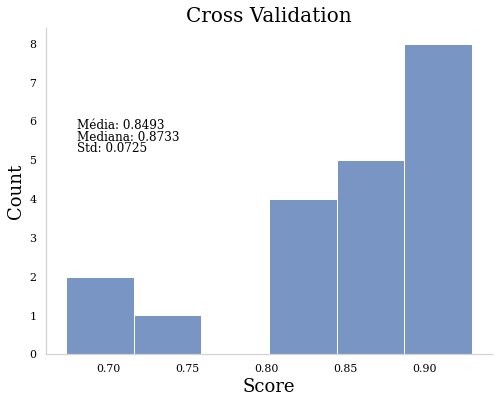

In [11]:
# cross validation

# escalando os dados
X, y = aux.full_preprocess(df_, which='cv')

# modelo
lr = LogisticRegression()

# plotando os scores e informações estatísticas
aux.plot_scores(lr, X, y, 20, [.68, 5.8])

### Regressão Logística - V2

In [9]:
keep_cols = [
    'balance', 'pdays', 'previous',
    'age', 'housing', 'contact', 'y'
]

cat_cols = [
    c for c in keep_cols if df[c].dtype != 'int32'
]

df_ = aux.col_encoder(df[keep_cols], cat_cols)

In [10]:
# treino e teste
X_train, X_test, y_train, y_test = aux.full_preprocess(df_, 'tt')

# instanciando o modelo
lr = LogisticRegression()

# treinando-o
lr.fit(X_train, y_train)

# realizando as predições
y_pred = lr.predict(X_test)

# métricas de avaliação
aux.score_metrics(lr, X_train, X_test, y_train, y_test, y_pred)

MAE: 0.1565217391304348
RSME: 0.39562828403747224
Acurácia (teste, treino): (0.8434782608695652, 0.8506239757973024)


In [11]:
aux.plot_report_confusion(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1323
           1       0.93      0.75      0.83      1322

    accuracy                           0.84      2645
   macro avg       0.86      0.84      0.84      2645
weighted avg       0.86      0.84      0.84      2645

     Predito     0     1   All
Real                          
0             1246    77  1323
1              337   985  1322
All           1583  1062  2645


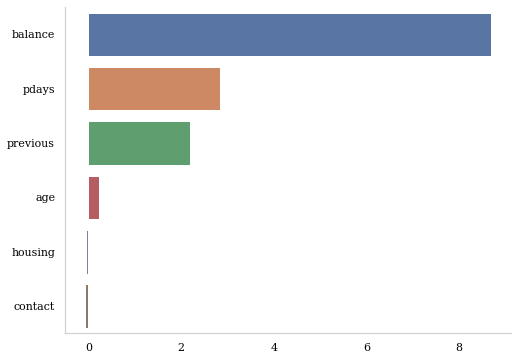

In [15]:
X = df_.drop('y', axis=1)
aux.plot_features(lr.coef_, X.columns)

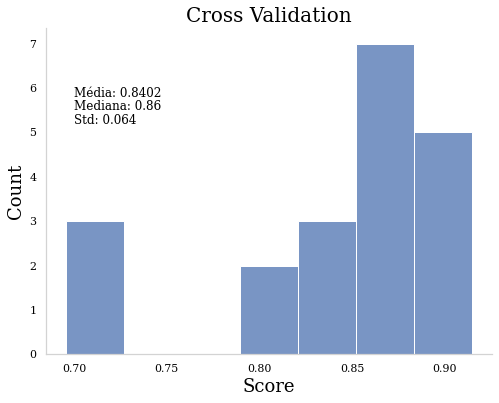

In [16]:
# cross validation

X, y = aux.full_preprocess(df_, 'cv')

# modelo
lr = LogisticRegression()

aux.plot_scores(lr, X, y, 20, [.7, 5.8])

### Regressão Logística - V3

In [15]:
keep_cols = [
    'balance', 'pdays', 'previous',
    'age', 'y'
]

cat_cols = [
    c for c in keep_cols if df[c].dtype != 'int32'
]

df_ = aux.col_encoder(df[keep_cols], cat_cols)

X_train, X_test, y_train, y_test = aux.full_preprocess(df_, 'tt')

# instanciando o modelo
lr = LogisticRegression()

# treinando-o
lr.fit(X_train, y_train)

# realizando as predições
y_pred = lr.predict(X_test)

# métricas de avaliação
aux.score_metrics(lr, X_train, X_test, y_train, y_test, y_pred)

MAE: 0.1504725897920605
RSME: 0.38790796562079066
Acurácia (teste, treino): (0.8495274102079395, 0.8460859699987394)


In [16]:
aux.plot_report_confusion(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1322
           1       0.93      0.75      0.83      1323

    accuracy                           0.85      2645
   macro avg       0.86      0.85      0.85      2645
weighted avg       0.86      0.85      0.85      2645

     Predito     0     1   All
Real                          
0             1250    72  1322
1              326   997  1323
All           1576  1069  2645


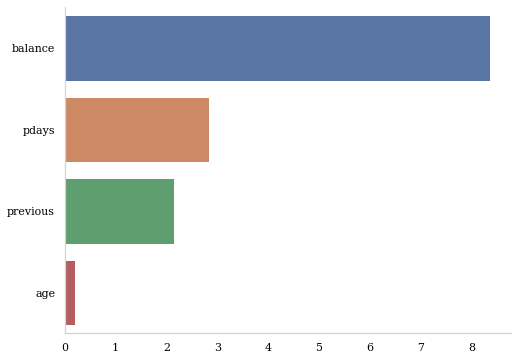

In [17]:
X = df_.drop('y', axis=1)
aux.plot_features(lr.coef_, X.columns)

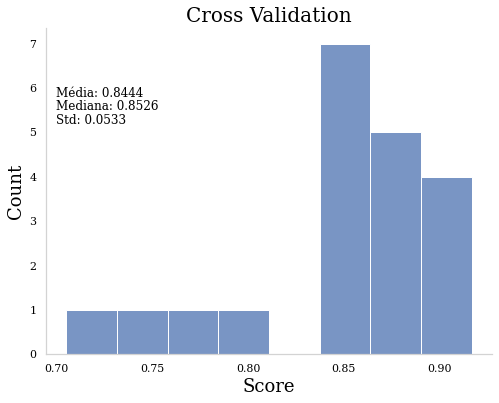

In [18]:
# cross validation

X, y = aux.full_preprocess(df_, 'cv')

# modelo
lr = LogisticRegression()

aux.plot_scores(lr, X, y, 20, [.7, 5.8])

#### 3.1.1 Tunning

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

Parâmetros a serem otimizados:
- C
- solver

In [20]:
# dados processados
X, y = aux.full_preprocess(df_, 'pip')

# pipeline
pip_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

parameters_grid = {
    'lr__C': [.001, .01, .1, 1, 10, 100],
    'lr__solver': ('newton-cg', 'lbfgs')
}

grid = GridSearchCV(pip_lr, parameters_grid, cv=20, scoring='accuracy')

grid.fit(X, y)


print(
    f'Melhores parâmetros: {grid.best_params_}\n'
    f'Score: {grid.best_score_}'
)

Melhores parâmetros: {'lr__C': 10, 'lr__solver': 'newton-cg'}
Score: 0.8458204445208224


#### 3.1.2 Re-execução com os parâmetros otimizados.

In [21]:
X_train, X_test, y_train, y_test = aux.full_preprocess(df_, 'tt')

# instanciando o modelo
lr = LogisticRegression(C=10, solver='newton-cg')

# treinando-o
lr.fit(X_train, y_train)

# realizando as predições
y_pred = lr.predict(X_test)

# métricas de avaliação
aux.score_metrics(lr, X_train, X_test, y_train, y_test, y_pred)

MAE: 0.15500945179584122
RSME: 0.3937123973103225
Acurácia (teste, treino): (0.8449905482041588, 0.8486070843312744)


In [22]:
aux.plot_report_confusion(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1322
           1       0.95      0.73      0.83      1323

    accuracy                           0.84      2645
   macro avg       0.86      0.85      0.84      2645
weighted avg       0.86      0.84      0.84      2645

     Predito     0     1   All
Real                          
0             1268    54  1322
1              356   967  1323
All           1624  1021  2645


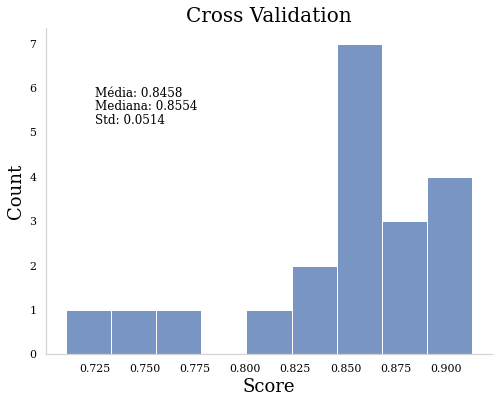

In [62]:
# cross validation

X, y = aux.full_preprocess(df_, 'cv')

# modelo
lr = LogisticRegression(C=10, solver='newton-cg')

aux.plot_scores(lr, X, y, 20, [.725, 5.8])

### 3.2 SVM

In [23]:
from sklearn import svm

In [23]:
cat_cols = [
    c for c in df.columns if df[c].dtype != 'int32'
]

df_ = aux.col_encoder(df, cat_cols)


X_train, X_test, y_train, y_test = aux.full_preprocess(df_, 'tt')

# instanciando o modelo
clf = svm.SVC()

# treinando-o
clf.fit(X_train, y_train)

# predições
y_pred = clf.predict(X_test)

# métricas
aux.score_metrics(clf, X_train, X_test, y_train, y_test, y_pred)

MAE: 0.14858223062381853
RSME: 0.3854636566835044
Acurácia (teste, treino): (0.8514177693761815, 0.8608344888440691)


In [24]:
aux.plot_report_confusion(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.97      0.87      1323
           1       0.96      0.73      0.83      1322

    accuracy                           0.85      2645
   macro avg       0.87      0.85      0.85      2645
weighted avg       0.87      0.85      0.85      2645

     Predito     0     1   All
Real                          
0             1287    36  1323
1              357   965  1322
All           1644  1001  2645


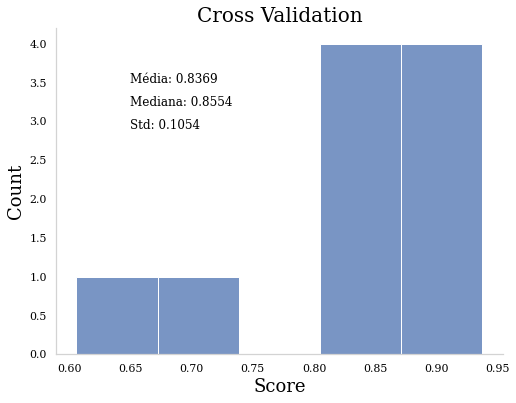

In [26]:
# cross validation

X, y = aux.full_preprocess(df_, 'cv')

# modelo
clf = svm.SVC()

aux.plot_scores(clf, X, y, 10, [.65, 3.5])

#### 3.2.1 Tunning

In [27]:
X, y = aux.full_preprocess(df_, 'pip')

pip_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', svm.SVC())
])

parameters_grid = {
    'clf__C': [.001, .01, .1, 1, 10, 100],
    'clf__kernel': ('linear', 'poly', 'rbf')
}

grid = GridSearchCV(pip_svm, parameters_grid, cv=5, scoring='accuracy')

grid.fit(X, y)


print(
    f'Melhores parâmetros: {grid.best_params_}\n'
    f'Score: {grid.best_score_}'
)

Melhores parâmetros: {'clf__C': 100, 'clf__kernel': 'linear'}
Score: 0.831640501056903


#### 3.2.2 Re-execução
Apesar do GridSearch ter retornado $C=100$ , iremos utilizar $C = 1$ , pois não é possível notar uma variação apreciável entre os dois e o segundo mostra-se muito mais rápido em execução.

In [29]:
X_train, X_test, y_train, y_test = aux.full_preprocess(df_, 'tt')

# instanciando o modelo
clf = svm.SVC(C=1, kernel='linear')

# treinando-o
clf.fit(X_train, y_train)

# predições
y_pred = clf.predict(X_test)

# métricas
aux.score_metrics(clf, X_train, X_test, y_train, y_test, y_pred)

MAE: 0.14366729678638943
RSME: 0.37903469074266727
Acurácia (teste, treino): (0.8563327032136105, 0.8511281986638094)


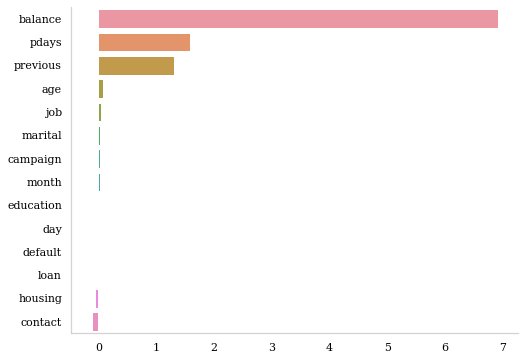

In [30]:
X = df_.drop('y', axis=1)
aux.plot_features(clf.coef_, X.columns)

### SVM V2

In [24]:
keep_cols = [
    'balance', 'pdays', 'previous',
    'age', 'y'
]

cat_cols = [
    c for c in keep_cols if df[c].dtype != 'int32'
]

df_ = aux.col_encoder(df[keep_cols], cat_cols)

X_train, X_test, y_train, y_test = aux.full_preprocess(df_, 'tt')

# instanciando o modelo
clf = svm.SVC(kernel='linear')

# treinando-o
clf.fit(X_train, y_train)

# predições
y_pred = clf.predict(X_test)

# métricas
aux.score_metrics(clf, X_train, X_test, y_train, y_test, y_pred)

MAE: 0.14858223062381853
RSME: 0.3854636566835044
Acurácia (teste, treino): (0.8514177693761815, 0.8446993571158452)


In [25]:
aux.plot_report_confusion(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1322
           1       0.95      0.75      0.83      1323

    accuracy                           0.85      2645
   macro avg       0.87      0.85      0.85      2645
weighted avg       0.87      0.85      0.85      2645

     Predito     0     1   All
Real                          
0             1265    57  1322
1              336   987  1323
All           1601  1044  2645


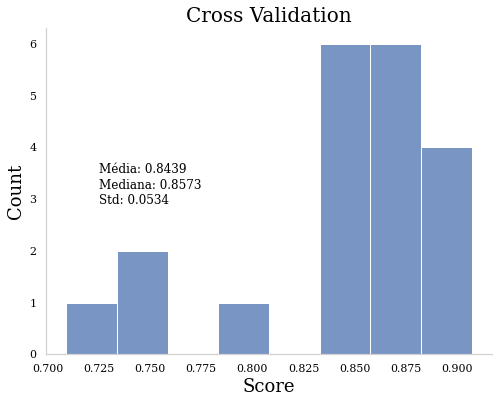

In [26]:
# cross validation

X, y = aux.full_preprocess(df_, 'cv')

# modelo
clf = svm.SVC(kernel='linear')

aux.plot_scores(clf, X, y, 20, [.725, 4.5])

### 3.3 Naive Bayes

In [44]:
from sklearn.naive_bayes import GaussianNB

In [47]:
cat_cols = [
    c for c in df.columns if df[c].dtype != 'int32'
]

df_ = aux.col_encoder(df, cat_cols)


X_train, X_test, y_train, y_test = aux.full_preprocess(df_, 'tt')

# instanciando o modelo
gnb = GaussianNB()

# treinando-o
gnb.fit(X_train, y_train)

# predições
y_pred = gnb.predict(X_test)

# métricas
aux.score_metrics(gnb, X_train, X_test, y_train, y_test, y_pred)

MAE: 0.1724007561436673
RSME: 0.41521170039350686
Acurácia (teste, treino): (0.8275992438563327, 0.8223874952729107)


In [48]:
aux.plot_report_confusion(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1323
           1       0.98      0.67      0.79      1322

    accuracy                           0.83      2645
   macro avg       0.87      0.83      0.82      2645
weighted avg       0.87      0.83      0.82      2645

     Predito     0    1   All
Real                         
0             1308   15  1323
1              441  881  1322
All           1749  896  2645


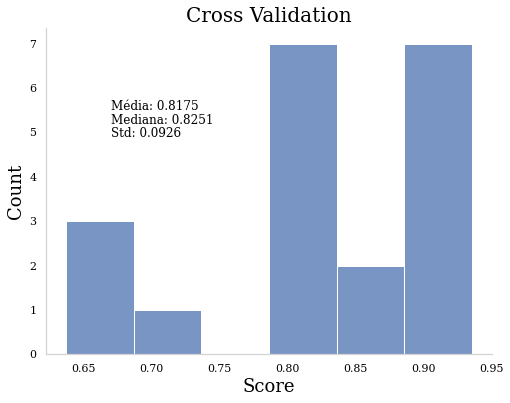

In [49]:
# cross validation

X, y = aux.full_preprocess(df_, 'cv')

# modelo
gnb = GaussianNB()

aux.plot_scores(gnb, X, y, 20, [.67, 5.5])

## 4. Conclusões
Neste projeto de classes binárias (variável de resposta: sim ou não) foram avaliados os modelos de *regressão logística*, *SVM* e *Naive Bayes*. Devido ao tempo de execução, métricas de erro e simplicidade do modelo, escolhemos o de regressão logística como o mais apropriado. Este nos permitiu rankear os atributos de modo a simplificá-lo para apenas quatro, em ordem decrescente de relevância: **i)** balance; **ii)** pdays; **iii)** previous; e **iv)** age. O tunning dos parâmetros com estes atributos nos retornou $C = 10$ e solver $=$ newton-cg, nos fornecendo uma acurácia média de 84.58%. Quanto ao modelo de SVM, seu primeiro tunning nos indicou kernel $=$ linear, nos possibilitando avaliar os coeficientes (pesos) dos atributos e chegarmos nas mesmas conclusões.